## imports

In [73]:
!pip install scikit-learn --upgrade -q
!pip install kaleido -q
!pip install plotly -q
import plotly.io as pio
pio.renderers.default = "iframe_connected"
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline


import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [74]:
df = pd.read_csv("Walmart_Store_sales.csv")

## EDA

In [75]:
df.shape

(150, 8)

In [76]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [77]:
df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [78]:
#Check of missing values share
print(100*df.isna().sum()/df.shape[0])

Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64


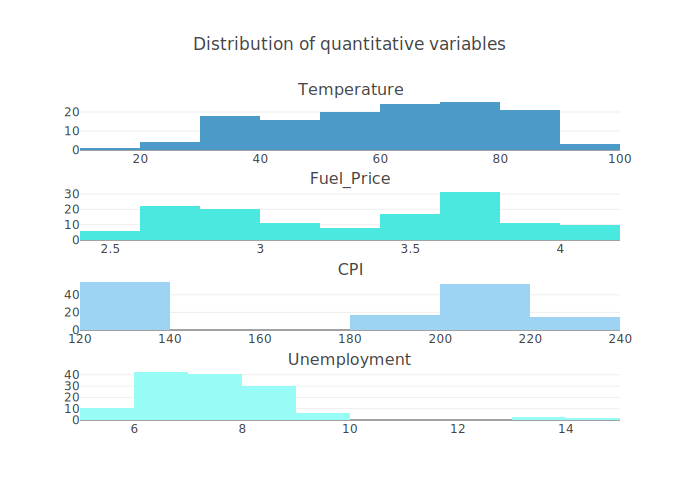

In [79]:
#Quantitative features distribution
from plotly.subplots import make_subplots

# Distribution of each numeric variable
num_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig1 = make_subplots(rows = len(num_features), cols = 1, subplot_titles = num_features)
for i in range(len(num_features)):
    fig1.add_trace(
        go.Histogram(
            x = df[num_features[i]], nbinsx = 10),
        row = i + 1,
        col = 1)
fig1.update_layout(
        title = go.layout.Title(text = "Distribution of quantitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig1.show()

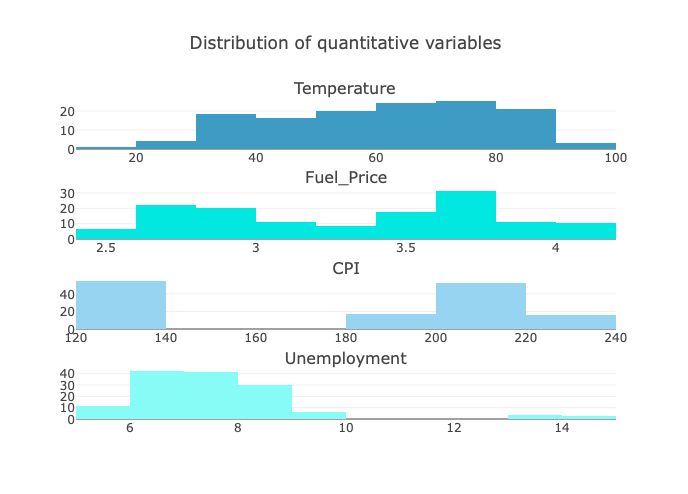

In [1]:
from IPython.display import display, Image
display(Image(filename='img/quantitative_variables_distribution.png'))

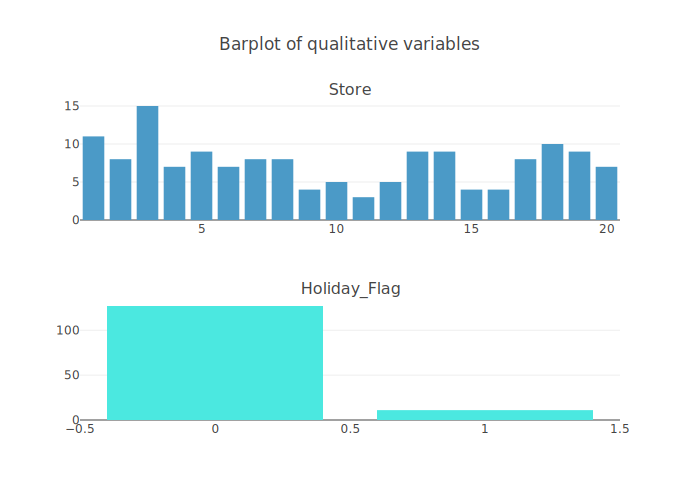

In [80]:
# Categorical features distribution
from plotly.subplots import make_subplots

# Barplot of each qualitative variable
cat_features = ['Store', 'Holiday_Flag']
fig2 = make_subplots(rows = len(cat_features), cols = 1, subplot_titles = cat_features)
for i in range(len(cat_features)):
    
    x_coords = df[cat_features[i]].value_counts().index.tolist()
    y_coords = df[cat_features[i]].value_counts().tolist()
    
    fig2.add_trace(
        go.Bar(
            x = x_coords,
            y = y_coords),
        row = i + 1,
        col = 1)
fig2.update_layout(
        title = go.layout.Title(text = "Barplot of qualitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig2.show()

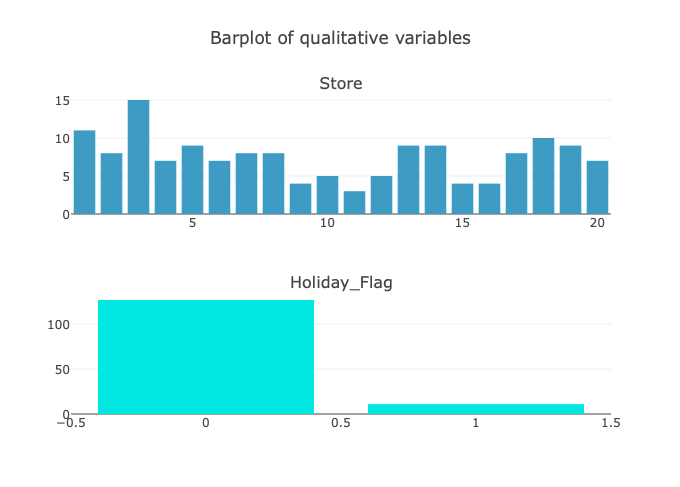

In [2]:
display(Image(filename='img/qualitative_variables_distribution.png'))

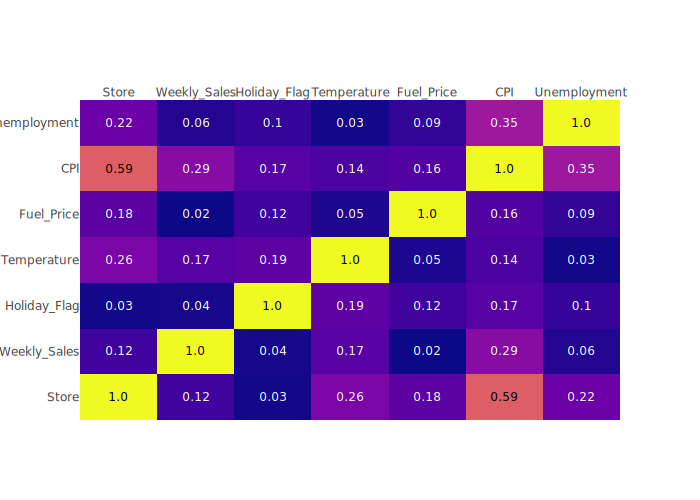

In [81]:
# Correlation matrix
corr_matrix = abs(round(df.corr(),2))

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist())


fig.show()

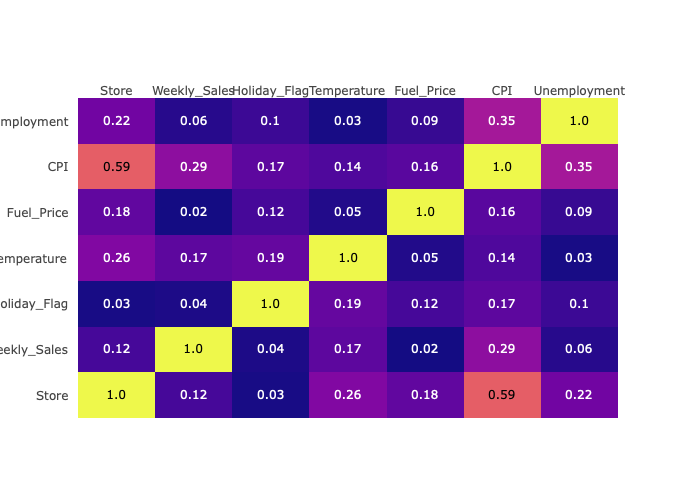

In [3]:
display(Image(filename='img/correlation_matrix.png'))

In [82]:
# Features VS target correlation
abs(corr_matrix).loc[:,"Weekly_Sales"].sort_values(ascending=False)

Weekly_Sales    1.00
CPI             0.29
Temperature     0.17
Store           0.12
Unemployment    0.06
Holiday_Flag    0.04
Fuel_Price      0.02
Name: Weekly_Sales, dtype: float64

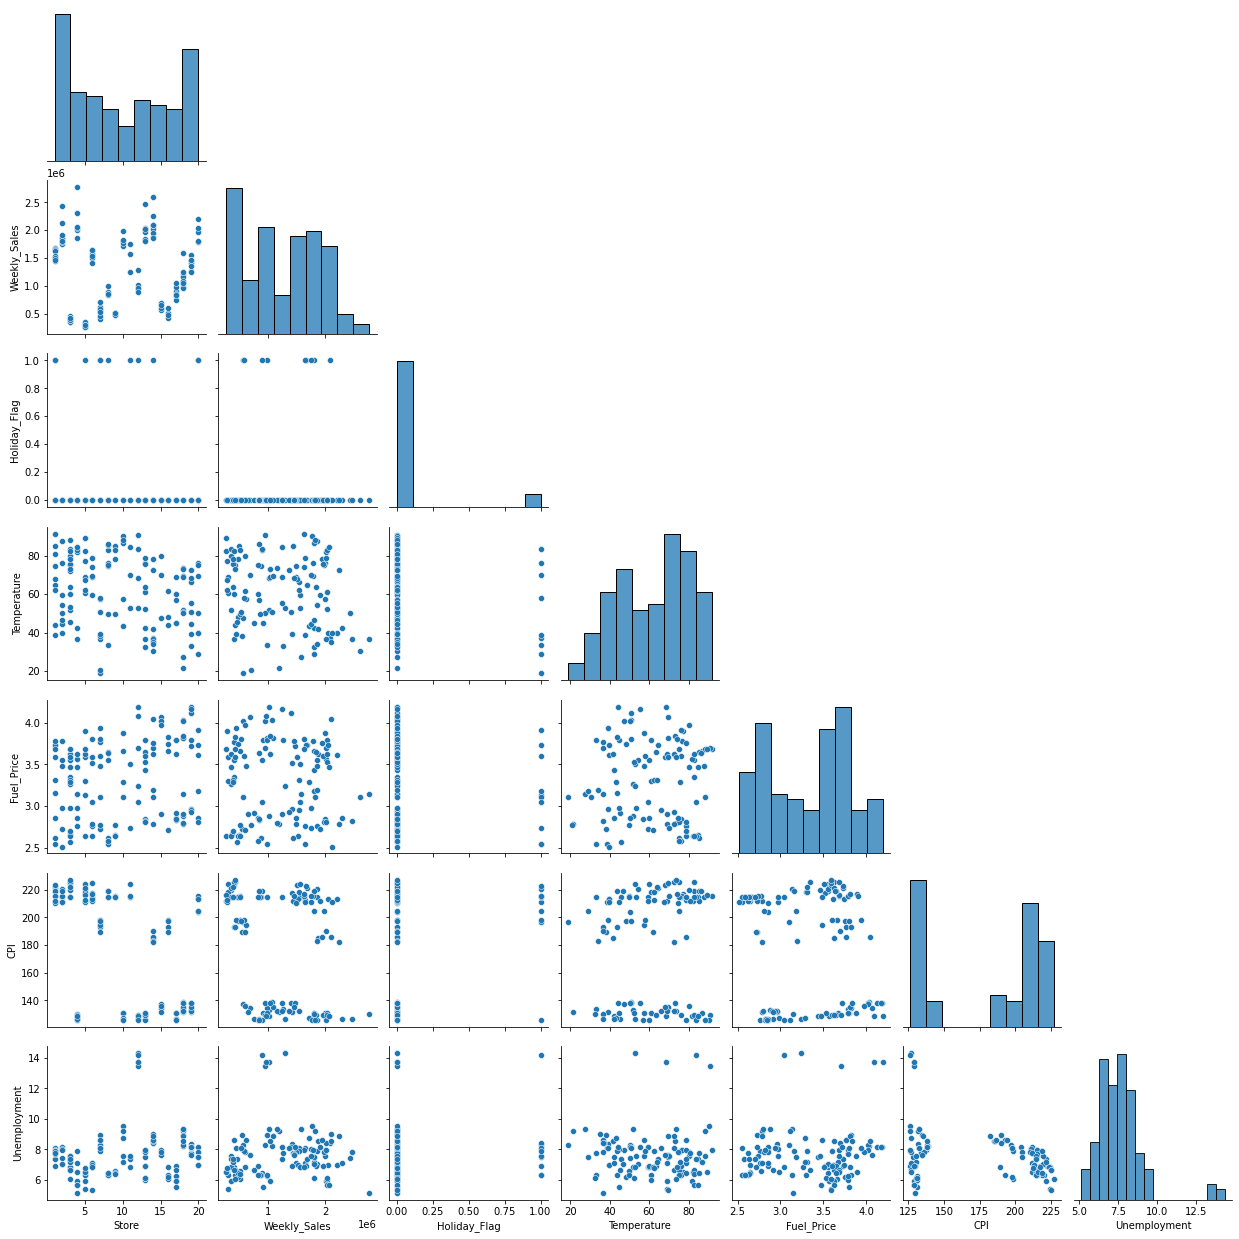

In [83]:
#Detailed correlations between each column of the dataset
sns.pairplot(df,corner=True)

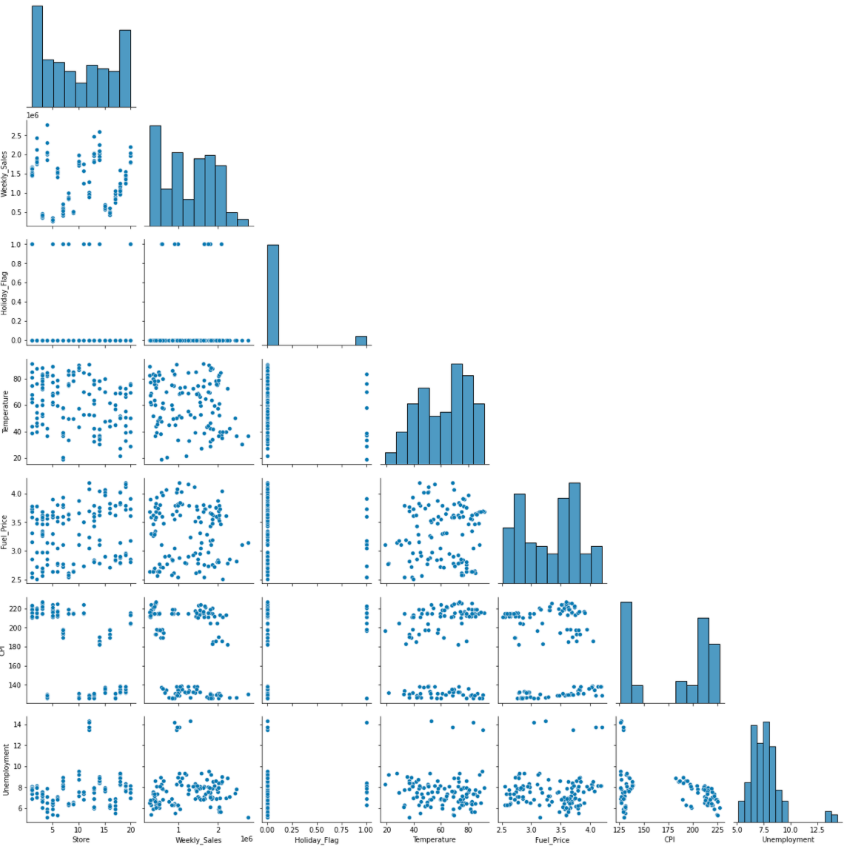

In [4]:
display(Image(filename='img/detailed_correlation_matrix.png'))

## Cleaning & addition of new features

In [84]:
#Transformation and addtion of new columns from Date
df.dropna(subset=['Date'],inplace=True)
df['Date']= pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['year'] = df['Date'].dt.year
df['day_of_week'] = df['Date'].dt.dayofweek
df = df.drop(['Date'], axis=1)

#Deletion of rows with missing values
df.dropna(subset=['Weekly_Sales'],inplace=True)
df.dropna(subset=['Holiday_Flag'],inplace=True)
df.dropna(subset=['Temperature'],inplace=True)
df.dropna(subset=['Fuel_Price'],inplace=True)
df.dropna(subset=['CPI'],inplace=True)
df.dropna(subset=['Unemployment'],inplace=True)

In [85]:
df = df.iloc[:, [0,2,3,4,5,6,7,8,9,10,1]]

In [86]:
df.head(5)

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,day,year,day_of_week,Weekly_Sales
1,13.0,0.0,42.38,3.435,128.616064,7.470,3,25,2011,4,1807545.43
4,6.0,0.0,78.89,2.759,212.412888,7.092,5,28,2010,4,1644470.66
6,15.0,0.0,69.80,4.069,134.855161,7.658,3,6,2011,6,695396.19
7,20.0,0.0,39.93,3.617,213.023623,6.961,3,2,2012,4,2203523.20
10,8.0,0.0,82.92,3.554,219.070197,6.425,8,19,2011,4,895066.50


In [87]:
df.shape

(75, 11)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 1 to 149
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         75 non-null     float64
 1   Holiday_Flag  75 non-null     float64
 2   Temperature   75 non-null     float64
 3   Fuel_Price    75 non-null     float64
 4   CPI           75 non-null     float64
 5   Unemployment  75 non-null     float64
 6   month         75 non-null     int64  
 7   day           75 non-null     int64  
 8   year          75 non-null     int64  
 9   day_of_week   75 non-null     int64  
 10  Weekly_Sales  75 non-null     float64
dtypes: float64(7), int64(4)
memory usage: 7.0 KB


In [89]:
#Conversion of Store and Holiday_Flag to integer
df["Store"] = df["Store"].astype(int)
df["Holiday_Flag"] = df["Holiday_Flag"].astype(int)

In [90]:
#Deletion if the outliers
list_of_columns_with_outliers = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for c in list_of_columns_with_outliers:
    ouliers_bottom = (df[c].mean())-(3*df[c].std())
    print(c, ouliers_bottom)
    ouliers_top = (df[c].mean())+(3*df[c].std())
    print(c, ouliers_top)
    df = df.loc[(df[c] > ouliers_bottom) & (df[c] < ouliers_top)]

Temperature 8.452653619972061
Temperature 112.48654638002796
Fuel_Price 1.8438835008324301
Fuel_Price 4.8079564991675685
CPI 55.60711070119552
CPI 296.5397646748045
Unemployment 2.368728545184055
Unemployment 12.952178121482609


In [91]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = df.loc[:,target_name]
X = df.loc[:,[c for c in df.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
1     1807545.43
4     1644470.66
6      695396.19
7     2203523.20
10     895066.50
Name: Weekly_Sales, dtype: float64

    Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
1      13             0        42.38       3.435  128.616064         7.470   
4       6             0        78.89       2.759  212.412888         7.092   
6      15             0        69.80       4.069  134.855161         7.658   
7      20             0        39.93       3.617  213.023623         6.961   
10      8             0        82.92       3.554  219.070197         6.425   

    month  day  year  day_of_week  
1       3   25  2011            4  
4       5   28  2010            4  
6       3    6  2011            6  
7       3    2  2012            4  
10      8   19  2011            4  



In [92]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 2)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [93]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

In [94]:
# Split of categorical VS numeric features
categorical_features = [0,1]
categorical_transformer = OneHotEncoder(drop='first')
numeric_features = [2,3,4,5,6,7,8,9]
numeric_transformer = StandardScaler()

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),    
        ('num', numeric_transformer, numeric_features)
        ]
    )

In [95]:
X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [96]:
# Trainint of the model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression()

In [97]:
# Generation of the predicted values
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [98]:
# Score of the model
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9901261954731984
R2 score on test set :  0.9404633137061709


<AxesSubplot:>

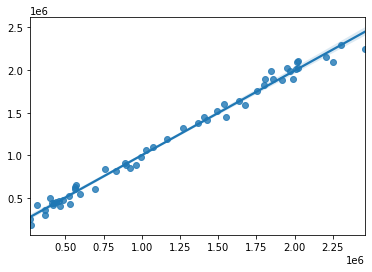

In [99]:
# Visualization of the model performance on the train set
sns.regplot(x=Y_train,y=Y_train_pred)

<AxesSubplot:>

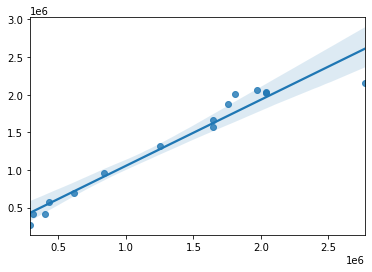

In [100]:
# Visualization of the model performance on the test set
sns.regplot(x=Y_test,y=Y_test_pred)

## Coefficients

In [101]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)

In [111]:
featureencoder.transformers_[0][1].transform
#featureencoder.transformers_[0][1].get_feature_names(go)

<bound method OneHotEncoder.transform of OneHotEncoder(drop='first')>

In [102]:
coefficients.columns =["Feature", "coefficient"]
coefficients["coefficient"] = abs(coefficients["coefficient"])
coefficients.sort_values(by='coefficient', ascending=False)


,Feature,coefficient
2,Temperature,3.214538e+06
10,NaN,3.155718e+06
8,year,3.002954e+06
16,NaN,2.325739e+06
15,NaN,1.896508e+06
14,NaN,1.881382e+06
12,NaN,1.622287e+06
11,NaN,1.430519e+06
1,Holiday_Flag,1.285997e+06
3,Fuel_Price,1.223418e+06


## Regularized model

In [103]:
ridge_regressor = Ridge()

In [104]:
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(ridge_regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.8564416658171355


In [105]:
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

In [106]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9855183890898679
R2 score on test set :  0.9104381963840328
